# Stationarity of Turkish Electricity Consumption Data
                                                                                                  Alperen Köksal

   In this work we are interest with the forecasting the daily electricity consumption data which is provided by EPİAŞ. In order to get accurate forecasts, stationarity analysis is needed to be done by using several techniques. After getting stationary time series data, a final model will be fitted by using autoregressive and moving avarage components and forecast will be done with this model. Forecasted daily electricity consumption data will be compared to actual data by using some accuracy measurements such as: daily bias, MAPE and WMAPE.

#### Manipulating the hourly electricity consumption data to get daily consumption data

In [25]:
library(data.table,quietly = TRUE,warn.conflicts = FALSE)
library(ggplot2,quietly = TRUE,warn.conflicts = FALSE)
library(zoo,quietly = TRUE,warn.conflicts = FALSE)
library(lubridate,quietly = TRUE,warn.conflicts = FALSE)
library(xts,quietly = TRUE,warn.conflicts = FALSE)
library(forecast,quietly = TRUE,warn.conflicts = FALSE)
library(urca,quietly = TRUE,warn.conflicts = FALSE)

setwd("C:/Users/a_kok/Desktop/Dersler/IE 360/HW4")

consumption <- fread("Consumption.csv")


setnames(consumption,'Tarih',"Date")
setnames(consumption,'Tüketim Miktarı (MWh)',"Consumption")
consumption[,Date:=as.Date(Date,format = "%d.%m.%Y")]
consumption[,Consumption:=gsub("\\.","",Consumption)]
consumption[,Consumption:=gsub("\\,",".",Consumption)]
consumption[,Consumption:=as.numeric(Consumption)]
daily_consumption = consumption[,mean(Consumption),by = Date]
setnames(daily_consumption,"V1","Consumption")

#### Creating a basic model to analyze outliers

In [26]:
daily_consumption[,woy:=weekdays(Date)]
daily_consumption[,mon:=as.factor(month(Date))]
daily_consumption[,Year:= year(Date)]
daily_consumption[,trend:= 1:.N]



Call:
lm(formula = Consumption ~ woy + mon + Year + trend, data = daily_consumption)

Residuals:
     Min       1Q   Median       3Q      Max 
-12140.2   -712.5    252.0   1163.7   5601.8 

Coefficients:
               Estimate Std. Error t value Pr(>|t|)    
(Intercept)   1.380e+06  4.440e+06   0.311   0.7560    
woyCumartesi -1.656e+03  1.988e+02  -8.327  < 2e-16 ***
woyÇarşamba   2.252e+02  1.986e+02   1.134   0.2570    
woyPazar     -4.980e+03  1.986e+02 -25.073  < 2e-16 ***
woyPazartesi -9.399e+02  1.986e+02  -4.732 2.44e-06 ***
woyPerşembe   3.382e+02  1.986e+02   1.703   0.0888 .  
woySalı      -1.224e+01  1.986e+02  -0.062   0.9509    
mon2         -4.651e+02  3.184e+02  -1.460   0.1444    
mon3         -2.477e+03  4.419e+02  -5.605 2.49e-08 ***
mon4         -4.483e+03  6.025e+02  -7.441 1.71e-13 ***
mon5         -4.653e+03  7.720e+02  -6.027 2.11e-09 ***
mon6         -3.100e+03  9.481e+02  -3.270   0.0011 ** 
mon7          2.486e+03  1.126e+03   2.208   0.0274 *  
mon8       

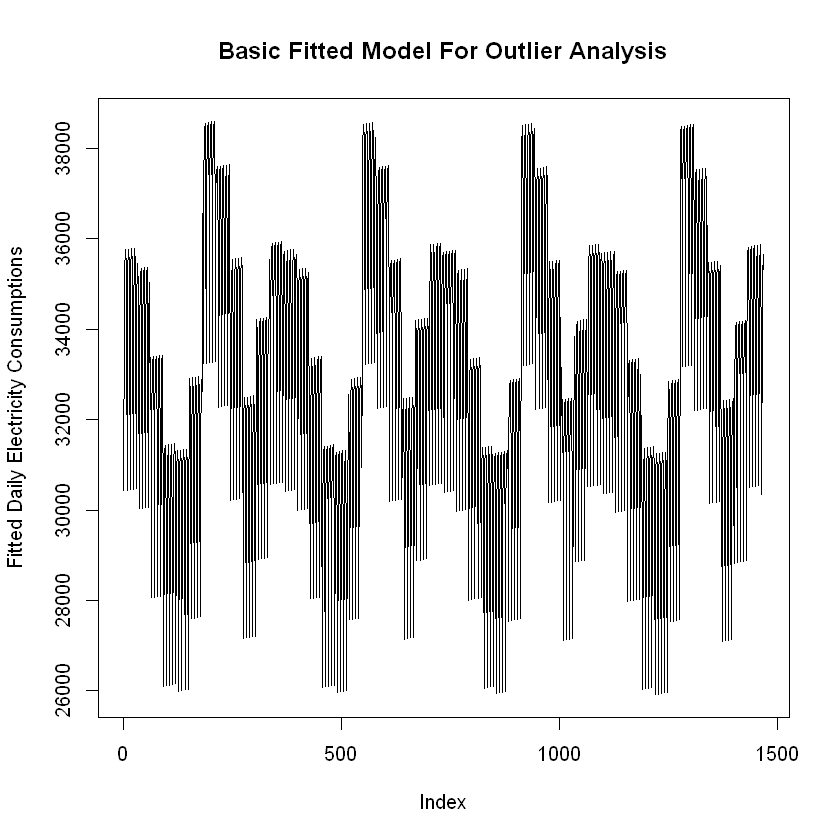

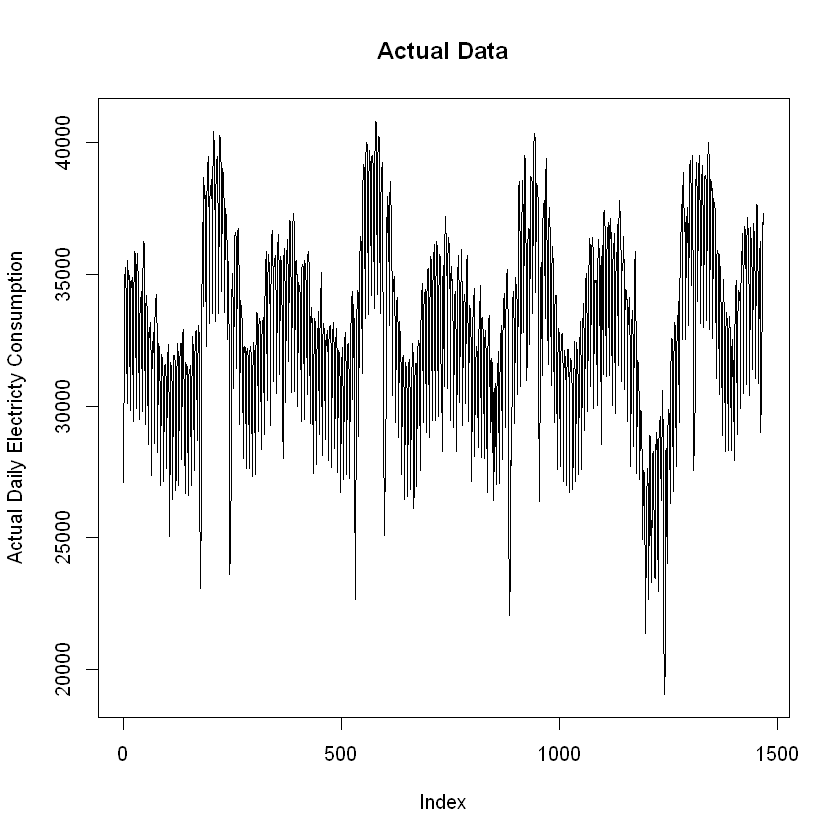

In [27]:
fit <- lm(Consumption~woy + mon + Year + trend,daily_consumption)
summary(fit)

plot(fitted(fit),type = "l", main = "Basic Fitted Model For Outlier Analysis", ylab = "Fitted Daily Electricity Consumptions")
plot(daily_consumption$Consumption,type = "l",main = "Actual Data",ylab = "Actual Daily Electricty Consumption")

This model will be useful for analyzing the outliers and grouping them with reasonable dummy variables

In [28]:
daily_consumption[,residuals:=residuals(fit)]
daily_consumption[year(Date) == 2017 & residuals < quantile(residuals,0.05)]
daily_consumption[year(Date) == 2018 & residuals < quantile(residuals,0.05)]
daily_consumption[year(Date) == 2019 & residuals < quantile(residuals,0.05)]
daily_consumption[year(Date) == 2020 & residuals < quantile(residuals,0.05)]
daily_consumption[year(Date) == 2021 & residuals < quantile(residuals,0.05)]

newyear_dates = c("2017-01-01","2018-01-01","2018-12-31","2019-01-01","2020-01-01","2021-01-01","2021-01-02")

ramadan_dates = c("2017-06-24","2017-06-25","2017-06-26","2017-06-27","2018-06-14","2018-06-15","2018-06-16","2018-06-17",
                 "2019-06-03","2019-06-04","2019-06-05","2019-06-06","2019-06-07","2020-05-23","2020-05-24","2020-05-25",
                 "2020-05-26","2020-05-27")

kurban_dates = c("2017-08-30","2017-08-31","2017-09-01","2017-09-02","2017-09-03","2017-09-04","2018-08-20","2018-08-21",
                "2018-08-22","2018-08-23","2018-08-24","2018-08-25","2019-08-10","2019-08-11","2019-08-12","2019-08-13",
                "2019-08-14","2020-07-30","2020-07-31","2020-08-01","2020-08-02","2020-08-03")

holidays = c("2018-10-29","2019-05-01","2019-07-15","2019-10-29","2020-05-19","2020-07-15")

corona_period = c("2020-04-07","2020-04-08","2020-04-09","2020-04-10","2020-04-11","2020-04-12","2020-04-13","2020-04-14",
                 "2020-04-15","2020-04-16","2020-04-17","2020-04-18","2020-04-19","2020-04-20","2020-04-23","2020-04-24",
                  "2020-04-25","2020-04-30","2020-05-01","2020-05-02","2020-05-09","2020-05-30")
daily_consumption[,newyear:= 0]
daily_consumption[Date %in% as.Date(newyear_dates),newyear:=1]

daily_consumption[,ramadan:= 0]
daily_consumption[Date %in% as.Date(ramadan_dates),ramadan:=1]

daily_consumption[,kurban:= 0]
daily_consumption[Date %in% as.Date(kurban_dates),kurban:=1]

daily_consumption[,holiday:= 0]
daily_consumption[Date %in% as.Date(holidays),holiday:=1]

daily_consumption[,corona:= 0]
daily_consumption[Date %in% as.Date(corona_period),corona:=1]
daily_consumption[year(Date) == 2020 & month(Date) == 4,corona:=1]


Date,Consumption,woy,mon,Year,trend,residuals
<date>,<dbl>,<chr>,<fct>,<dbl>,<int>,<dbl>
2017-01-01,27099.66,Pazar,1,2017,1,-3328.134
2017-06-24,27404.78,Cumartesi,6,2017,175,-3553.496
2017-06-25,23098.24,Pazar,6,2017,176,-4537.580
2017-06-26,23859.14,Pazartesi,6,2017,177,-7818.609
2017-06-27,25886.96,Salı,6,2017,178,-6720.190
2017-08-30,31163.56,Çarşamba,8,2017,242,-6360.989
2017-08-31,27547.64,Perşembe,8,2017,243,-10091.701
2017-09-01,23619.08,Cuma,9,2017,244,-11575.003
2017-09-02,24418.67,Cumartesi,9,2017,245,-9121.350


Date,Consumption,woy,mon,Year,trend,residuals
<date>,<dbl>,<chr>,<fct>,<dbl>,<int>,<dbl>
2018-01-01,28005.32,Pazartesi,1,2018,366,-6438.107
2018-06-14,27517.43,Perşembe,6,2018,530,-5392.785
2018-06-15,22882.44,Cuma,6,2018,531,-9691.290
2018-06-16,22662.85,Cumartesi,6,2018,532,-8256.820
2018-06-17,23546.44,Pazar,6,2018,533,-4050.772
2018-08-20,29505.24,Pazartesi,8,2018,597,-6812.101
2018-08-21,25106.55,Salı,8,2018,598,-12140.189
2018-08-22,26173.59,Çarşamba,8,2018,599,-11312.354
2018-08-23,27248.64,Perşembe,8,2018,600,-10352.090


Date,Consumption,woy,mon,Year,trend,residuals
<date>,<dbl>,<chr>,<fct>,<dbl>,<int>,<dbl>
2019-01-01,28267.30,Salı,1,2019,731,-7079.236
2019-05-01,27516.20,Çarşamba,5,2019,851,-3625.872
2019-06-03,26350.41,Pazartesi,6,2019,884,-5237.804
2019-06-04,22072.16,Salı,6,2019,885,-10445.449
2019-06-05,22273.82,Çarşamba,6,2019,886,-10482.986
2019-06-06,23602.54,Perşembe,6,2019,887,-9269.067
2019-06-07,27315.13,Cuma,6,2019,888,-5219.997
2019-07-15,31884.21,Pazartesi,7,2019,926,-5363.570
2019-08-10,31119.49,Cumartesi,8,2019,952,-4439.777


Date,Consumption,woy,mon,Year,trend,residuals
<date>,<dbl>,<chr>,<fct>,<dbl>,<int>,<dbl>
2020-01-01,28529.58,Çarşamba,1,2020,1096,-7029.863
2020-04-07,27562.33,Salı,4,2020,1193,-3447.561
2020-04-08,27470.68,Çarşamba,4,2020,1194,-3778.406
2020-04-09,27441.84,Perşembe,4,2020,1195,-3922.040
2020-04-10,26913.15,Cuma,4,2020,1196,-4114.248
2020-04-11,22600.57,Cumartesi,4,2020,1197,-6772.776
2020-04-12,21368.41,Pazar,4,2020,1198,-4682.476
2020-04-13,25590.96,Pazartesi,4,2020,1199,-4501.845
2020-04-14,26272.13,Salı,4,2020,1200,-4750.078


Date,Consumption,woy,mon,Year,trend,residuals
<date>,<dbl>,<chr>,<fct>,<dbl>,<int>,<dbl>
2021-01-01,28998.90,Cuma,1,2021,1462,-6312.563
2021-01-02,30276.93,Cumartesi,1,2021,1463,-3380.471


#### Grouped those days with reasonable variables like religious holidays, national holidays and corona period.


Call:
lm(formula = Consumption ~ woy + mon + Year + trend + kurban + 
    ramadan + newyear + corona + holiday, data = daily_consumption)

Residuals:
    Min      1Q  Median      3Q     Max 
-4509.3  -745.6    62.0   767.4  4742.3 

Coefficients:
               Estimate Std. Error t value Pr(>|t|)    
(Intercept)  -4.791e+05  2.876e+06  -0.167 0.867716    
woyCumartesi -1.527e+03  1.284e+02 -11.899  < 2e-16 ***
woyÇarşamba   2.668e+02  1.283e+02   2.080 0.037686 *  
woyPazar     -4.965e+03  1.282e+02 -38.728  < 2e-16 ***
woyPazartesi -8.144e+02  1.283e+02  -6.346 2.95e-10 ***
woyPerşembe   3.062e+02  1.282e+02   2.389 0.017025 *  
woySalı       6.651e+00  1.283e+02   0.052 0.958667    
mon2         -6.380e+02  2.060e+02  -3.097 0.001992 ** 
mon3         -2.584e+03  2.853e+02  -9.058  < 2e-16 ***
mon4         -3.238e+03  3.948e+02  -8.203 5.15e-16 ***
mon5         -4.066e+03  4.986e+02  -8.155 7.51e-16 ***
mon6         -2.140e+03  6.128e+02  -3.493 0.000492 ***
mon7          2.844e+03 

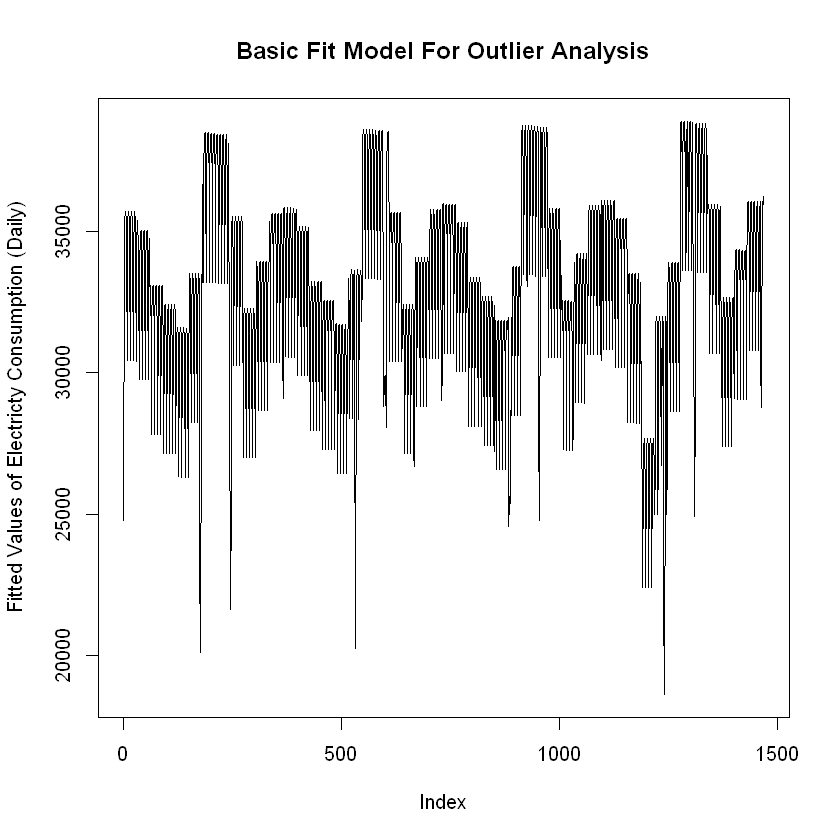

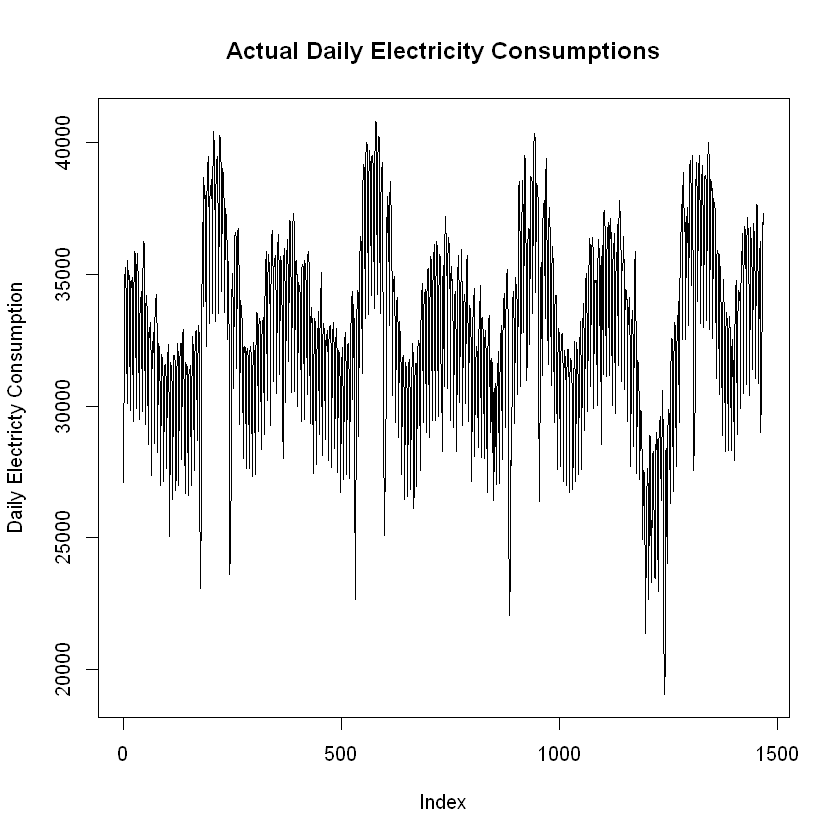

In [29]:
fit <- lm(Consumption~woy + mon + Year + trend + kurban + ramadan + newyear + corona + holiday,daily_consumption)
summary(fit)

plot(fitted(fit),type = "l",main = "Basic Fit Model For Outlier Analysis",ylab = "Fitted Values of Electricty Consumption (Daily)")
plot(daily_consumption$Consumption,type = "l",main = "Actual Daily Electricity Consumptions",ylab = "Daily Electricty Consumption")

daily_consumption[,residuals := residuals(fit)]


In [30]:
daily_consumption[,outlier_big:=0]
daily_consumption[residuals > quantile(residuals,0.95),outlier_big:=1]

#### Added the effects of days with big outliers with one dummy variable since we can not know the reason of those outliers. Doing this is not really healthy in this case but still may improve the prediction performance.


####################### 
# KPSS Unit Root Test # 
####################### 

Test is of type: mu with 7 lags. 

Value of test-statistic is: 0.1457 

Critical value for a significance level of: 
                10pct  5pct 2.5pct  1pct
critical values 0.347 0.463  0.574 0.739


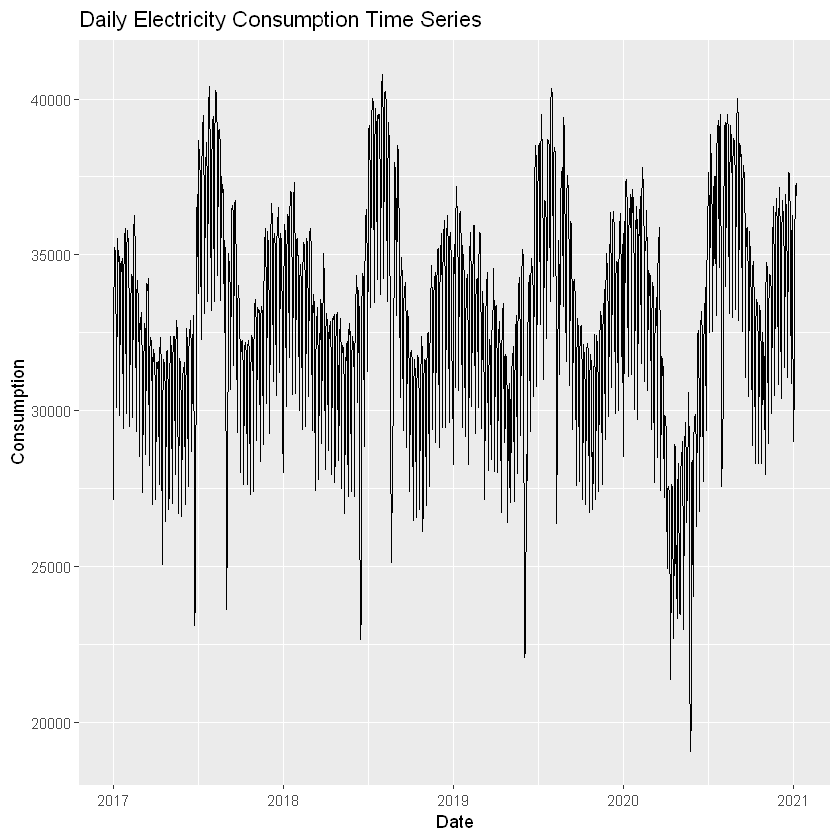

In [31]:
ggplot(daily_consumption,aes(x=Date,y=Consumption)) + geom_line() +
labs(title = "Daily Electricity Consumption Time Series")

unt_test=ur.kpss(daily_consumption$Consumption) 
summary(unt_test)

Seen from unit root test, test statistic is high and we can not say time series is stationary. Also when we observe the plot, we can see some seasonality and trend component. Some approaches are needed to be used to get stationary time series data.

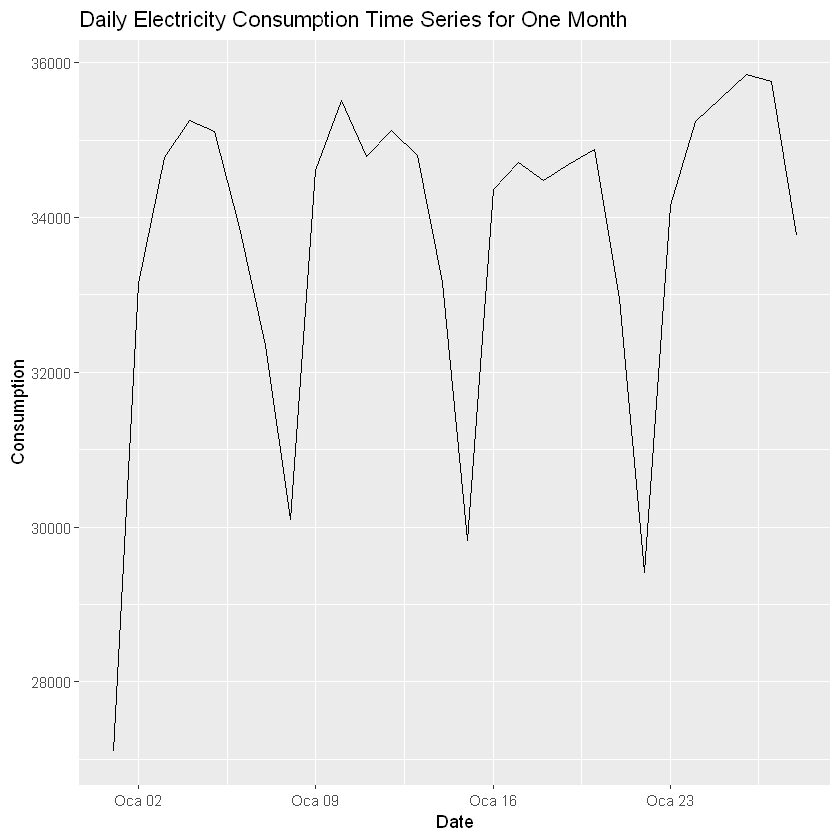

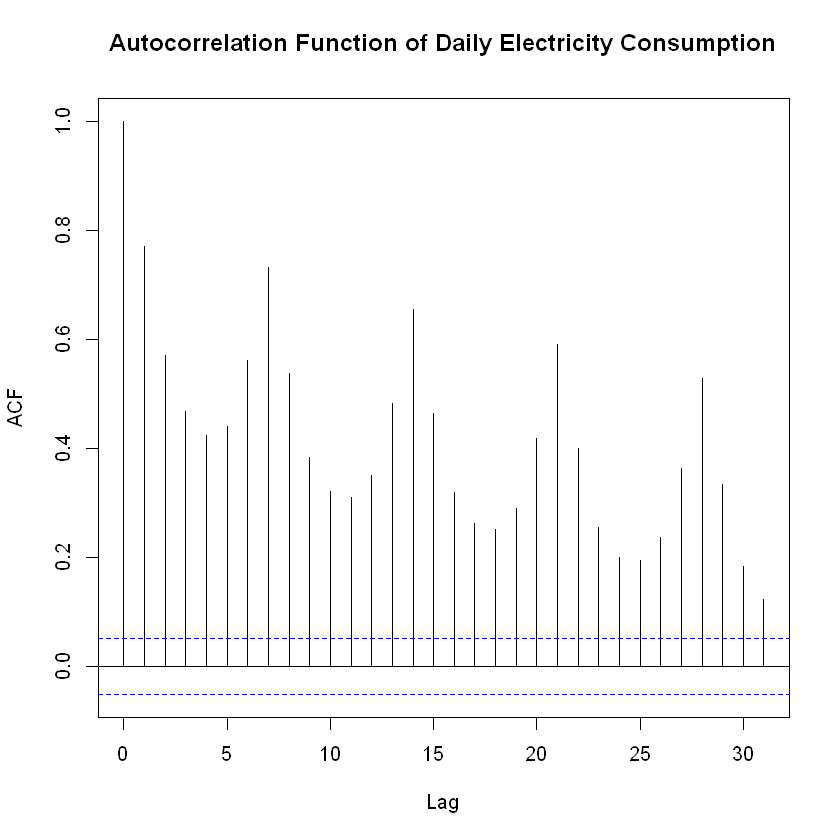

In [32]:
ggplot(daily_consumption[1:28],aes(x=Date,y=Consumption)) + geom_line() +
labs(title = "Daily Electricity Consumption Time Series for One Month")
acf(daily_consumption$Consumption,main = "Autocorrelation Function of Daily Electricity Consumption")

Seen from 4 week consumption data plot and autocorrelation function of time series data up to 30 lag, there is a weekly seasonality. We can get rid of that by using decompose function with frequency 7 or using differencing approach with lag 7. For this case differencing approach will be used.

Warning message:
"Removed 7 row(s) containing missing values (geom_path)."



####################### 
# KPSS Unit Root Test # 
####################### 

Test is of type: mu with 7 lags. 

Value of test-statistic is: 0.0121 

Critical value for a significance level of: 
                10pct  5pct 2.5pct  1pct
critical values 0.347 0.463  0.574 0.739


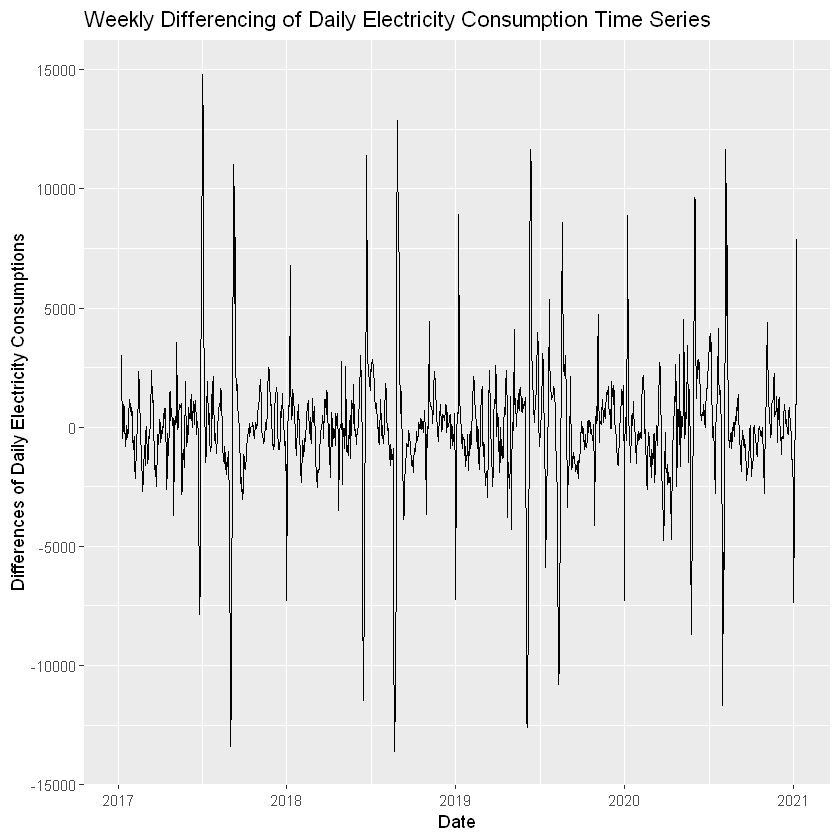

In [33]:
daily_consumption[,differ:=Consumption - shift(Consumption,7)]
ggplot(daily_consumption,aes(x=Date,y=differ)) + geom_line() + 
labs(title = "Weekly Differencing of Daily Electricity Consumption Time Series", y = "Differences of Daily Electricity Consumptions")
unt_test=ur.kpss(daily_consumption$differ) 
summary(unt_test)

Unit root test statistic is much lower compared to first test due to the weekly differencing approach. We can say that time series data is stationary enough to build autoregressive and moving average models since 0.0121 < 0.347. But we can not really say that the time series data obtained by using weekly differencing approach is stationary because test statistic is stil high.

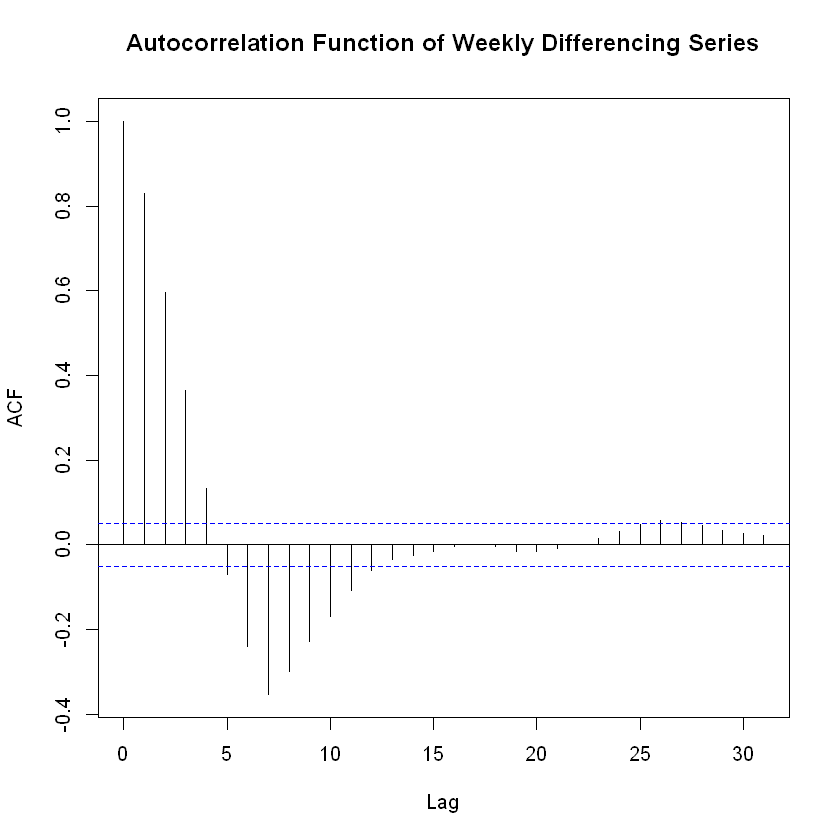

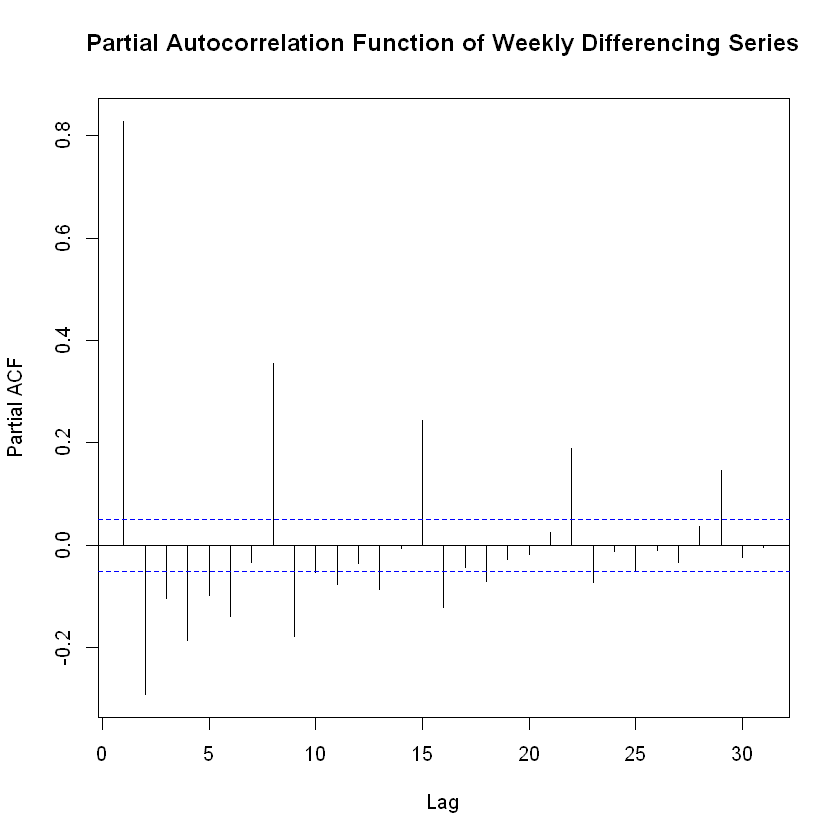

In [34]:
acf(daily_consumption$differ,na.action = na.pass,main = "Autocorrelation Function of Weekly Differencing Series")
pacf(daily_consumption$differ,na.action = na.pass,main = "Partial Autocorrelation Function of Weekly Differencing Series")

Autocorrelation plot indicates that time series data is highly positively autocorrelated till lag 4 and negatively correlated after with diminishing correlation. So autoregressive model with lag 1,2,3,4 can be useful in this case. From partial autocorellation plot, it can be seen that at lag 1 + 7k there is still some correlation that can be modeled with moving avarage.

#### Taking difference of all regressors with lag 7

In [35]:
daily_consumption[,dnewyear:= newyear - shift(newyear,7)]

daily_consumption[,dramadan:= ramadan - shift(ramadan,7)]

daily_consumption[,dkurban:= kurban - shift(kurban,7)]

daily_consumption[,dholiday:= holiday - shift(holiday,7)]

daily_consumption[,dcorona:= corona - shift(corona,7)]

daily_consumption[,doutlier_big := outlier_big - shift(outlier_big,7)]



Call:
lm(formula = differ ~ dnewyear + dramadan + dkurban + dholiday + 
    dcorona + doutlier_big, data = daily_consumption)

Residuals:
    Min      1Q  Median      3Q     Max 
-4911.3  -809.9    -0.3   821.2  6127.1 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)      9.375     36.120   0.260    0.795    
dnewyear     -6613.118    399.913 -16.536  < 2e-16 ***
dramadan     -8676.725    230.917 -37.575  < 2e-16 ***
dkurban      -8707.630    209.777 -41.509  < 2e-16 ***
dholiday     -3904.583    399.149  -9.782  < 2e-16 ***
dcorona      -2182.099    346.417  -6.299 3.96e-10 ***
doutlier_big  1355.295    125.262  10.820  < 2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 1381 on 1455 degrees of freedom
  (7 observations deleted due to missingness)
Multiple R-squared:  0.704,	Adjusted R-squared:  0.7028 
F-statistic: 576.7 on 6 and 1455 DF,  p-value: < 2.2e-16


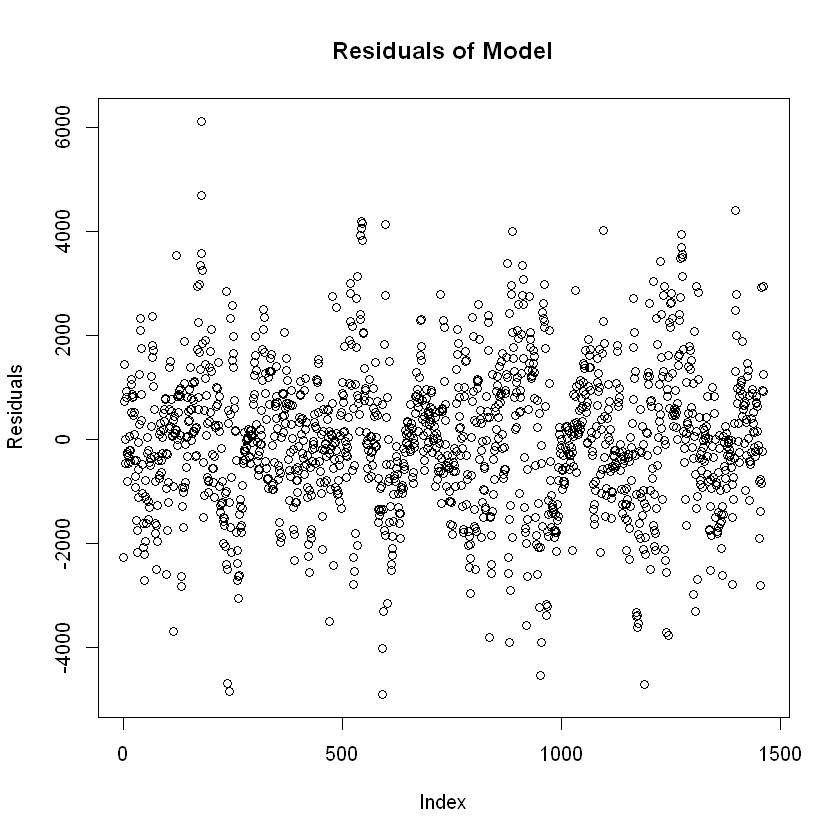

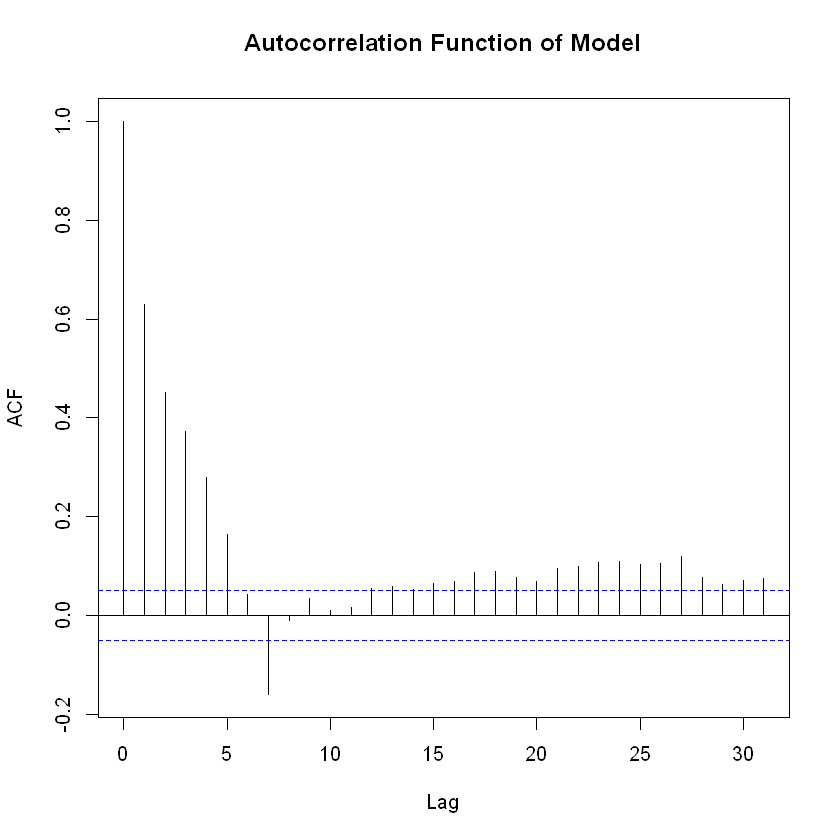

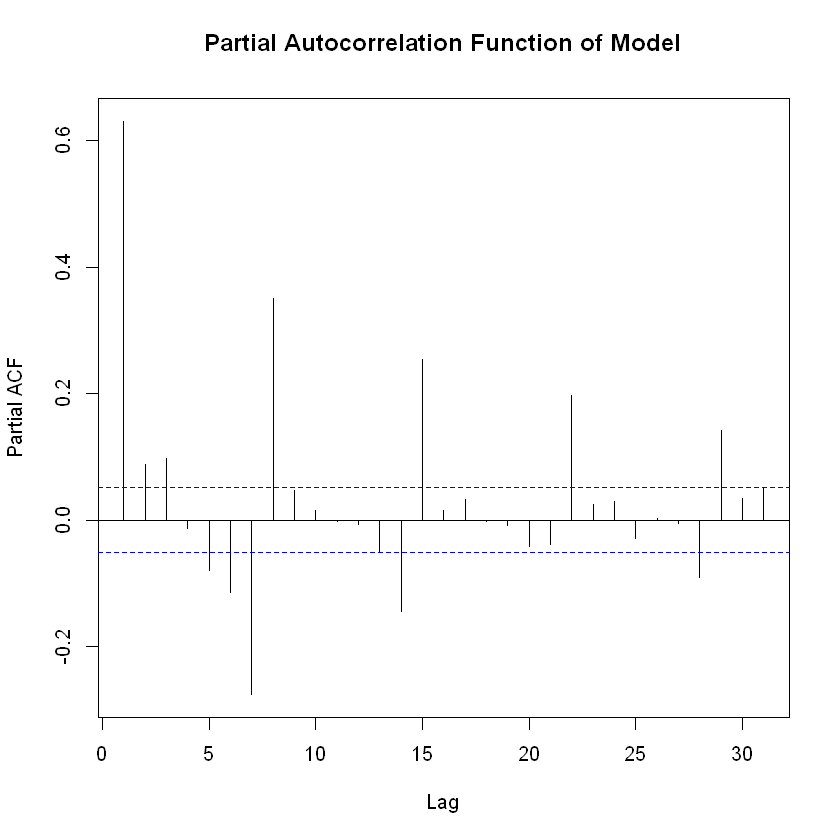

In [39]:
fit <- lm(differ~ dnewyear + dramadan + dkurban + dholiday + dcorona + doutlier_big, daily_consumption) 
summary(fit)

plot(residuals(fit),main = "Residuals of Model",ylab = "Residuals")
acf(residuals(fit),main = "Autocorrelation Function of Model")
pacf(residuals(fit),main = "Partial Autocorrelation Function of Model")

With this model we have still some outliers. Those can be explained by some independent variables or with further outlier analysis.

Autocorrelation and partial autocorrelation functions are better than before.

In [40]:
reg_matrix = cbind(daily_consumption$dnewyear,daily_consumption$dkurban,daily_consumption$dramadan,
                  daily_consumption$dcorona,daily_consumption$dholiday,daily_consumption$doutlier_big)

In [41]:
fitdiffer = auto.arima(daily_consumption$differ,xreg = reg_matrix, seasonal = F,trace = T)
fitdiffer


 Fitting models using approximations to speed things up...

 ARIMA(2,0,2) with non-zero mean : 24346.76
 ARIMA(0,0,0) with non-zero mean : 25300.4
 ARIMA(1,0,0) with non-zero mean : 24357.15
 ARIMA(0,0,1) with non-zero mean : 24717.47
 ARIMA(0,0,0) with zero mean     : 25298.45
 ARIMA(1,0,2) with non-zero mean : 24349.94
 ARIMA(2,0,1) with non-zero mean : 24344.96
 ARIMA(1,0,1) with non-zero mean : 24348.96
 ARIMA(2,0,0) with non-zero mean : 24345.78
 ARIMA(3,0,1) with non-zero mean : 24347.49
 ARIMA(3,0,0) with non-zero mean : 24347.77
 ARIMA(3,0,2) with non-zero mean : Inf
 ARIMA(2,0,1) with zero mean     : 24342.95
 ARIMA(1,0,1) with zero mean     : 24346.96
 ARIMA(2,0,0) with zero mean     : 24343.75
 ARIMA(3,0,1) with zero mean     : 24345.46
 ARIMA(2,0,2) with zero mean     : 24344.74
 ARIMA(1,0,0) with zero mean     : 24355.15
 ARIMA(1,0,2) with zero mean     : 24347.94
 ARIMA(3,0,0) with zero mean     : 24345.75
 ARIMA(3,0,2) with zero mean     : Inf

 Now re-fitting the best 

Series: daily_consumption$differ 
Regression with ARIMA(2,0,1) errors 

Coefficients:
         ar1     ar2     ma1       xreg1       xreg2       xreg3       xreg4
      0.4395  0.2149  0.4101  -5077.6986  -6050.3695  -5112.8520  -1155.4596
s.e.  0.1319  0.1041  0.1227    272.5481    286.5084    324.0261    336.3909
           xreg5      xreg6
      -2694.0532  1046.5352
s.e.    219.1081   100.8425

sigma^2 estimated as 991846:  log likelihood=-12163.59
AIC=24347.18   AICc=24347.33   BIC=24400.05

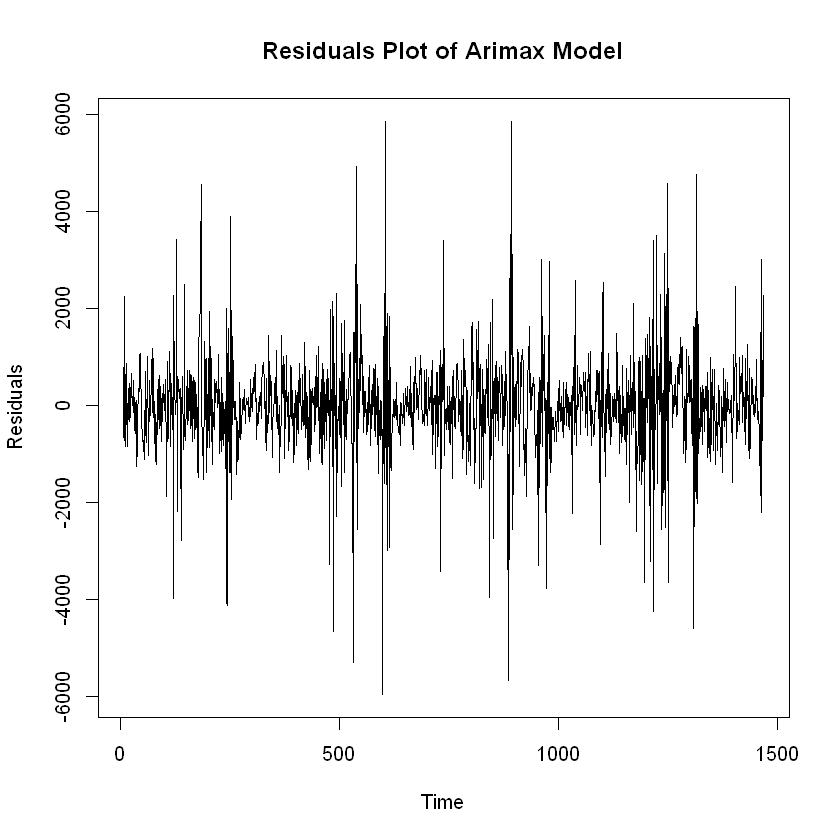

In [44]:
plot(fitdiffer$residuals,main = "Residuals Plot of Arimax Model",ylab = "Residuals")

Autocorrelation function with lag 2 and moving avarage term 1 is best fit to our model with the lowest AIC value.


####################### 
# KPSS Unit Root Test # 
####################### 

Test is of type: mu with 7 lags. 

Value of test-statistic is: 0.0097 

Critical value for a significance level of: 
                10pct  5pct 2.5pct  1pct
critical values 0.347 0.463  0.574 0.739


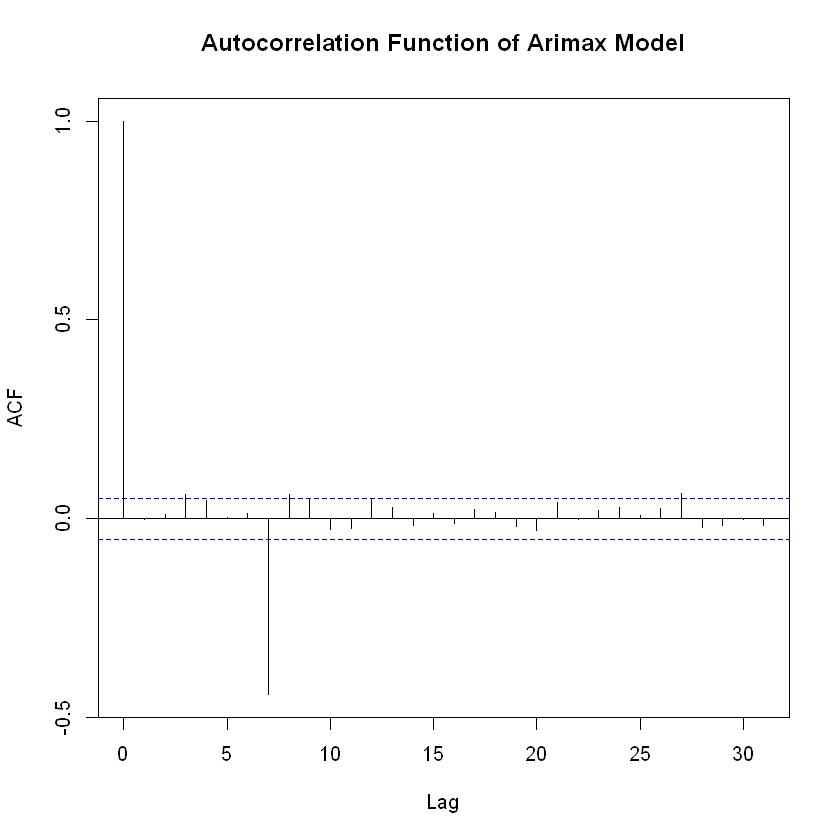

In [49]:
unt_test=ur.kpss(fitdiffer$fitted) 
summary(unt_test)
acf(fitdiffer$residuals,na.action = na.pass,main = "Autocorrelation Function of Arimax Model")

Although this model is more stationary than the time series data of weekly differencing, it can be still improved by further outlier analysing or using different approaches for transformation. This model will be used in our forecast application.

#### Adding forecast dates to daily electricity consumption data

In [50]:
forecast_dates = c("2021-01-09","2021-01-10","2021-01-11","2021-01-12","2021-01-13","2021-01-14","2021-01-15"
                  ,"2021-01-16","2021-01-17","2021-01-18","2021-01-19","2021-01-20","2021-01-21","2021-01-22")
for(i in 1:14){
        daily_consumption = rbind(daily_consumption,data.table(Date=as.Date(forecast_dates[i])),fill=T)       
}


#### Adding new dummy regressors with 0 values in order to eliminate effects of those days.

In [51]:
daily_consumption[Date >= as.Date("2021-01-09"),dnewyear:=0]
daily_consumption[Date >= as.Date("2021-01-09"),dkurban:=0]
daily_consumption[Date >= as.Date("2021-01-09"),dramadan:=0]
daily_consumption[Date >= as.Date("2021-01-09"),dholiday:=0]
daily_consumption[Date >= as.Date("2021-01-09"),dcorona:=0]
daily_consumption[Date >= as.Date("2021-01-09"),doutlier_big:=0]


After forecasting the weekly differencing values with dummy regressors for 14 days period, it is needed to be transformed to consumption data back by using 2 approaches. One is using the last week data twice and other is using the forecasted daily electricity consumption values of first week to transform weekly differencing data of second week back.

In [52]:
newreg_matrix = cbind(daily_consumption$dnewyear,daily_consumption$dkurban,daily_consumption$dramadan,
                  daily_consumption$dcorona,daily_consumption$dholiday,daily_consumption$doutlier_big)
forecastedrandom = forecast(fitdiffer,h = 14,xreg = tail(newreg_matrix,14))
daily_consumption[,fdiffer:= c(rep(NA,7),fitdiffer$fitted,forecastedrandom$mean)]
daily_consumption[Date <= "2021-01-15",fitted1:=fdiffer + shift(Consumption,7)]
daily_consumption[Date > "2021-01-15",fitted1:=fdiffer + tail(daily_consumption[is.na(Consumption) == F,Consumption],7)]


daily_consumption[Date <= "2021-01-15",fitted2:=fdiffer + shift(Consumption,7)]
daily_consumption[Date > "2021-01-15",fitted2:=tail(daily_consumption$fdiffer,7)
                  + daily_consumption[Date %between% as.Date(c("2021-01-09","2021-01-15")),fitted2]]



#### Manipulating testdata

In [53]:
testdata <- fread("testdata.csv",nrow = (14*24))
setnames(testdata,'Tarih',"Date")
setnames(testdata,'Tüketim Miktarı (MWh)',"Consumption")
testdata[,Consumption:=gsub("\\.","",Consumption)]
testdata[,Consumption:=gsub("\\,",".",Consumption)]
testdata[,Consumption:=as.numeric(Consumption)]
testdata[,Date:=as.Date(Date,format = "%d.%m.%Y")]

In [54]:
daily_testdata = testdata[,mean(Consumption),by = Date]$V1
daily_consumption[Date >= "2021-01-09",Consumption:=daily_testdata]

In [55]:
accu = function(actual, forecast){
    n = length(actual)
    error = actual - forecast
    mean = mean(actual)
    sd = sd(actual)
    FBias = sum(error)/sum(actual)
    MAPE = sum(abs(error/actual)) / n
    RMSE = sqrt(sum(error^2) / n)
    MAD = sum(abs(error)) / n
    WMAPE = MAD / mean
    l = data.frame(n, mean, sd, FBias, MAPE, RMSE, MAD, WMAPE)
    return(l)
}

Computing the accuracy measures for the forecasted daily electricty consumption values

In [56]:
accu(tail(daily_consumption$Consumption,14),tail(daily_consumption$fitted1,14))

n,mean,sd,FBias,MAPE,RMSE,MAD,WMAPE
<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
14,37044.41,2566.215,0.04491165,0.04937213,2292.258,1832.634,0.04947128


In [57]:
accu(tail(daily_consumption$Consumption,14),tail(daily_consumption$fitted2,14))

n,mean,sd,FBias,MAPE,RMSE,MAD,WMAPE
<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
14,37044.41,2566.215,0.03196994,0.03623318,1631.507,1353.216,0.03652957


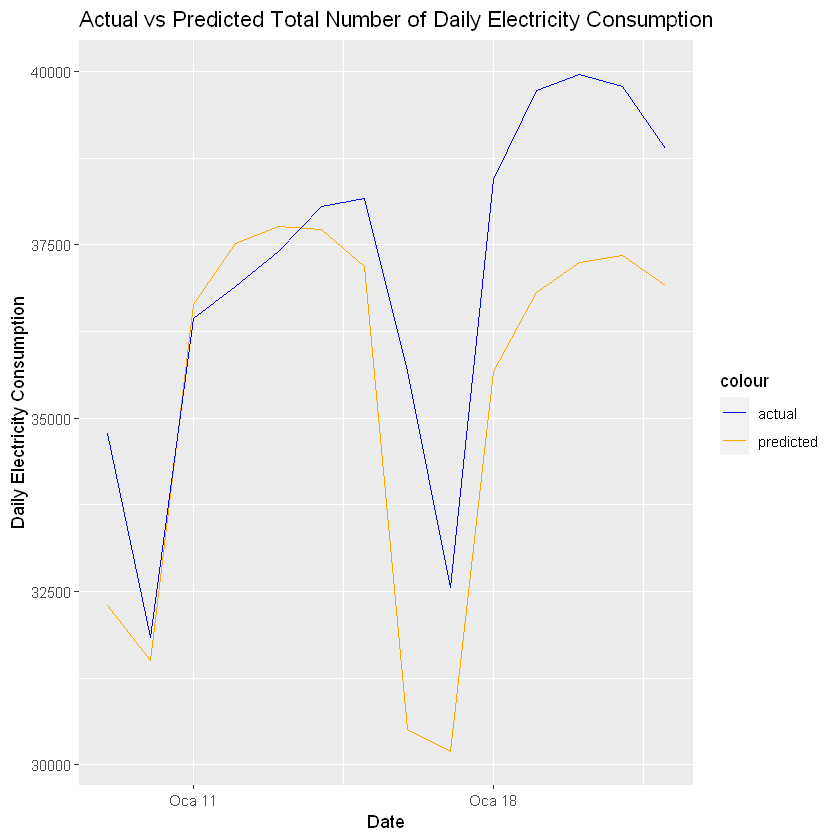

In [63]:
cols <- c("predicted" = "orange", "actual" = "blue")
ggplot() + 
  geom_line(data = daily_consumption[Date > "2021-01-08"], aes(x = Date, y = fitted1,color = "predicted")) +  
  geom_line(data = daily_consumption[Date > "2021-01-08"], aes(x = Date, y = Consumption,color = "actual")) +
  labs(xlab = "Date", title = 'Actual vs Predicted Total Number of Daily Electricity Consumption' ) +
  ylab("Daily Electricity Consumption") +
  scale_color_manual(values = cols)

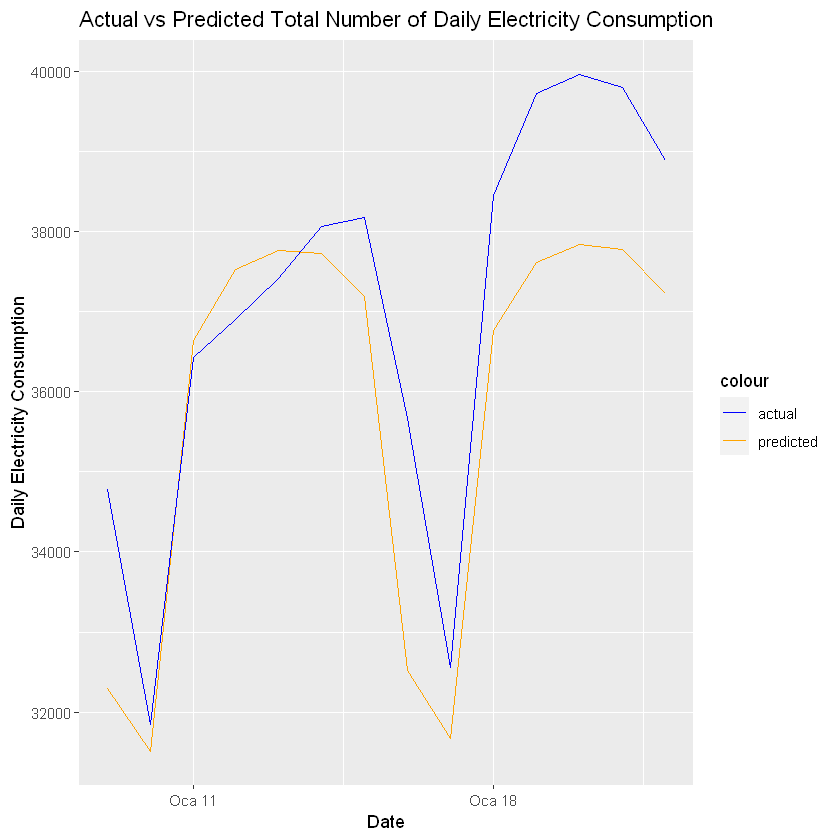

In [64]:
cols <- c("predicted" = "orange", "actual" = "blue")
ggplot() + 
  geom_line(data = daily_consumption[Date > "2021-01-08"], aes(x = Date, y = fitted2,color = "predicted")) +  
  geom_line(data = daily_consumption[Date > "2021-01-08"], aes(x = Date, y = Consumption,color = "actual")) +
  labs(xlab = "Date", title = 'Actual vs Predicted Total Number of Daily Electricity Consumption' ) +
  ylab("Daily Electricity Consumption") +
  scale_color_manual(values = cols)

Seen from accuracy measurements and actual vs predicted graphs, second approach for transforming the forecasted differencing values to forecasted daily electricity consumption values has a better performance than first approach. But still we have error terms of week 1 and error terms of week 2 in our prediction. To avoid that, we can make 1 week predictions with this model or use another transformation approach.

 ## Conclusion


   In this work, daily electricity consumption time series data is transformed in to stationary series by using the weekly differencing transformation. Another approach could be using decompose function with seven frequency. After getting time series data with differencing approach, some significant outliers are eliminated by using dummy regressors and autoregressive and moving avarage models are used with lag two and moving avarage one component. Final model is used for forecast application and two approaches are used to transform the forecasted differencing values to daily electricity consumption values. Accuracy measurements are computed after getting the actual values of forecasted period. Although accuracy measurements are quite good, still better predictions can be made by further analysing the outliers or using different deseasonalize approaches.